## Import Libraries and Functions

In [82]:
#libraries
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from s3fs.core import S3FileSystem
import numpy as np
import shapefile
from shapely.geometry.polygon import LinearRing
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

import codecs
import json

%matplotlib inline

#functions
from s3_functions import *
from shp_functions import *

## Define constants

In [2]:
s3 = S3FileSystem(anon=True)
bucket = 'ptrac-copano'
#extent = (-97.4, -96.6, 27.7, 28.44)
extent = (-97.3, -96.8, 27.9, 28.3)
zone_number = 14
zone_letter = 'R'
month_dict = {
    'April': '0401',
    'May': '0501',
    'June': '0601',
    'July': '0701',
    'August': '0801',
}
#s3.




## Read the coordinates, shapefile, and make the plotting mask

In [3]:
print('Reading coordinates')
coords, loni, lati = read_coords(zone_number, zone_letter, extent, s3, bucket)
print('Reading shapefile')
r, polygon, geoms = read_shapefile(s3, bucket)
#print('Creating mask')
#mask, lati, loni = create_mask(coords, polygon)
print('Reading mask')
#need to read it from s3
mask = read_mask(s3, bucket)
print('Done!')

Reading coordinates
Reading shapefile
Reading mask
Done!


#### Figure out a way to get the mask.json back and into an np array

## Define what happens when buttons are clicked

In [4]:
def read_data(b):
    #since the on_click functions doesn't return anything, need to make these global
    global lat, lon, outflw1, avesal
    
    #get the current state of the dropdown widgets
    year = year_dropdown.get_interact_value()
    month = month_dict[month_dropdown.get_interact_value()]
    
    #create the keys for the lat/lon files, this is their path in S3
    lat_key = 'data/{}/{}/lat.csv'.format(year, month)
    lon_key = 'data/{}/{}/lon.csv'.format(year, month)
    
    #pandas 0.20 uses s3fs to access S3 objects now (previous versions used boto or boto3)
    print('Reading latitude')
    lat = pd.read_csv(s3.open('{}/{}'.format(bucket, lat_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading longitude')
    lon = pd.read_csv(s3.open('{}/{}'.format(bucket, lon_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading velocity')
    outflw1 = read_outflw1(year, month, s3, bucket)
    print('Reading salinity')
    avesal = read_avesalD(year, month, s3, bucket)
    print('Done!')



## this will be the init_plot function

In [30]:
def init_plot(extent, geoms):
    ring_lats = [28.142815, 28.142622, 28.128572, 28.128588]
    ring_lons = [-97.057931, -97.041549, -97.041542, -97.057923]
    ring = LinearRing(list(zip(ring_lons, ring_lats)))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection=ccrs.Miller())
    ax.set_extent(extent, ccrs.Miller())
    ax.add_geometries(geoms, ccrs.Miller(), facecolor='none', edgecolor='black')
    ax.add_geometries([ring], ccrs.Miller(), facecolor='none', edgecolor='red')
    return ax

## this will be the first frame 

(28, 8595)

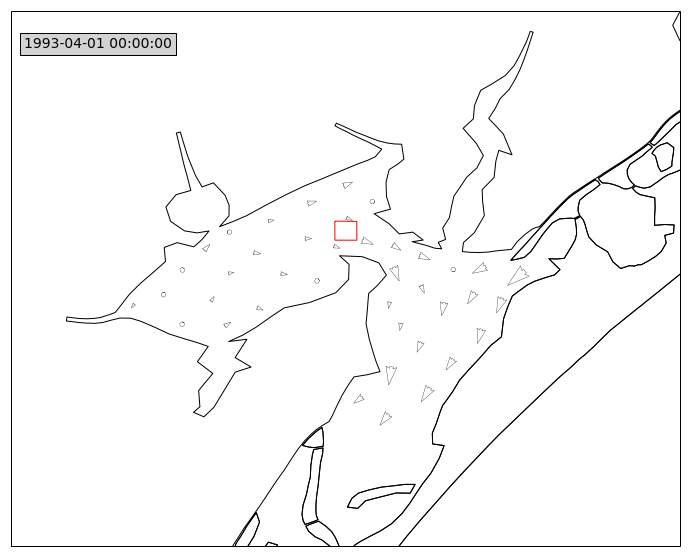

In [92]:
ax = init_plot(extent, geoms)
index = lon.index[0]
time_text = ax.text(0.02, 0.93, index, bbox=dict(facecolor='lightgray', alpha=1), 
                    fontsize=14, weight='medium', transform=ax.transAxes)
sctr = ax.scatter(lon.iloc[0], lat.iloc[0])
u = [outflw1[k]['u'][0] for k in outflw1]
v = [outflw1[k]['v'][0] for k in outflw1]
quiv = ax.quiver(cknodes['lon'], cknodes['lat'], u, v, scale=8, facecolor='white',
                 edgecolors='black', linewidth=0.3)
#sal = np.array(avesal.iloc[0])
#sali = griddata(coords['lon'], coords['lat'], sal, loni, lati, interp='linear')
#avesal.shape

[Date
 1993-04-01 01:00:00   -0.037710
 1993-04-01 02:00:00   -0.020971
 1993-04-01 03:00:00   -0.036857
 1993-04-01 04:00:00   -0.000921
 1993-04-01 05:00:00   -0.006067
 1993-04-01 06:00:00   -0.006326
 1993-04-01 07:00:00   -0.000876
 1993-04-01 08:00:00    0.004299
 1993-04-01 09:00:00    0.009309
 1993-04-01 10:00:00    0.007302
 1993-04-01 11:00:00    0.003911
 1993-04-01 12:00:00   -0.000577
 1993-04-01 13:00:00   -0.008418
 1993-04-01 14:00:00   -0.024648
 1993-04-01 15:00:00   -0.034106
 1993-04-01 16:00:00   -0.044295
 1993-04-01 17:00:00   -0.107445
 1993-04-01 18:00:00   -0.041752
 1993-04-01 19:00:00   -0.021166
 1993-04-01 20:00:00   -0.071103
 1993-04-01 21:00:00   -0.076760
 1993-04-01 22:00:00   -0.026154
 1993-04-01 23:00:00    0.016194
 1993-04-02 00:00:00   -0.021620
 1993-04-02 01:00:00   -0.029107
 1993-04-02 02:00:00   -0.008319
 1993-04-02 03:00:00   -0.010560
 1993-04-02 04:00:00   -0.016728
 1993-04-02 05:00:00   -0.020422
 1993-04-02 06:00:00    0.006541
    

In [66]:
cn = [int(x) for x in list(outflw1.keys())]
cknodes = coords.loc[cn]
cknodes

,lat,lon
1226,28.080899,-97.207613
1345,28.065759,-97.171985
1295,28.087837,-97.185864
1462,28.064427,-97.140201
1348,28.106277,-97.171794
1459,28.082848,-97.150318
1586,28.078318,-97.116040
1519,28.103665,-97.137489
1451,28.120950,-97.155521
1575,28.134578,-97.136700


## Create the widgets and buttons

In [5]:
year_dropdown = widgets.Dropdown(
    options = ['1993', '1995', '1997', '2007', '2009', '2011'],
    value = '1993',
    description = 'Year:',
)

month_dropdown = widgets.Dropdown(
    options = ['April', 'May', 'June', 'July', 'August'],
    value = 'April',
    description = 'Month:',
)

submit_button = widgets.Button(
    description = 'Get Data',
    button_style = 'info',
    tooltip = 'Click here to start downloading the appropriate data',
    icon = 'check',
)

display(year_dropdown, month_dropdown, submit_button)

submit_button.on_click(read_data)
#call the plotting function here
#submit_button.on_click(hw)

Reading latitude
Reading longitude
Reading velocity
Reading salinity
Done!
